In [1]:
import h5py 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs

In [2]:
henan25 = pd.read_csv('../../Data/points_SAF.csv')

henan25['lon'] = henan25['lon'].round(1)
henan25['lat'] = henan25['lat'].round(1)

henan_lon = henan25['lon']
henan_lat = henan25['lat']

lon_true = np.unique(henan25['lon'])
lat_true = np.unique(henan25['lat'])

res = 0.1

nlon, nlat = len(lon_true), len(lat_true)
lon_min, lon_max = lon_true.min(), lon_true.max()
lat_min, lat_max = lat_true.min(), lat_true.max()

target_n = 512

extra_lon = target_n - nlon
extra_lat = target_n - nlat

expand_lon_left = extra_lon // 2
expand_lon_right = extra_lon - expand_lon_left
expand_lat_down = extra_lat // 2
expand_lat_up = extra_lat - expand_lat_down

new_lon_min = (lon_min - expand_lon_left * res).round(1)
new_lon_max = (new_lon_min + (target_n - 1) * res).round(1)
new_lat_min = (lat_min - expand_lat_down * res).round(1)
new_lat_max = (new_lat_min + (target_n - 1) * res).round(1)

lon64 = (np.linspace(new_lon_min, new_lon_max, target_n)).round(1)
lat64 = (np.linspace(new_lat_min, new_lat_max, target_n)).round(1)

lon25 = (np.linspace(-179.9, 180, 3600)).round(1)
lat25 = (np.linspace(-90, 90, 1801)).round(1)

idx_lon25 = np.where((lon25 <= new_lon_max) & (lon25 >= new_lon_min))[0]
idx_lat25 = np.where((lat25 <= new_lat_max) & (lat25 >= new_lat_min))[0]

target_n_1 = 64

lon1 = np.linspace(-179, 180, 360)
lat1 = np.linspace(-90, 90, 181)

idx_lon1 = np.where((lon1 <= new_lon_max) & (lon1 >= new_lon_min))[0]
idx_lat1 = np.where((lat1 <= new_lat_max) & (lat1 >= new_lat_min))[0]

mask = np.zeros((len(lat64), len(lon64)), dtype=bool)

for lon, lat in zip(henan_lon, henan_lat):
    i = np.argmin(np.abs(lat64 - lat)) 
    j = np.argmin(np.abs(lon64 - lon))  
    mask[i, j] = True

In [3]:
era5_masked = np.load('era5_masked_SAF.npy')
preds_masked = np.load('preds_masked_SAF.npy')


mask = (~np.isnan(era5_masked)) & (~np.isnan(preds_masked))
rmse = np.sqrt(np.mean((preds_masked[mask] - era5_masked[mask])**2))

print('RMSE =', rmse)


RMSE = 0.0740181649458598


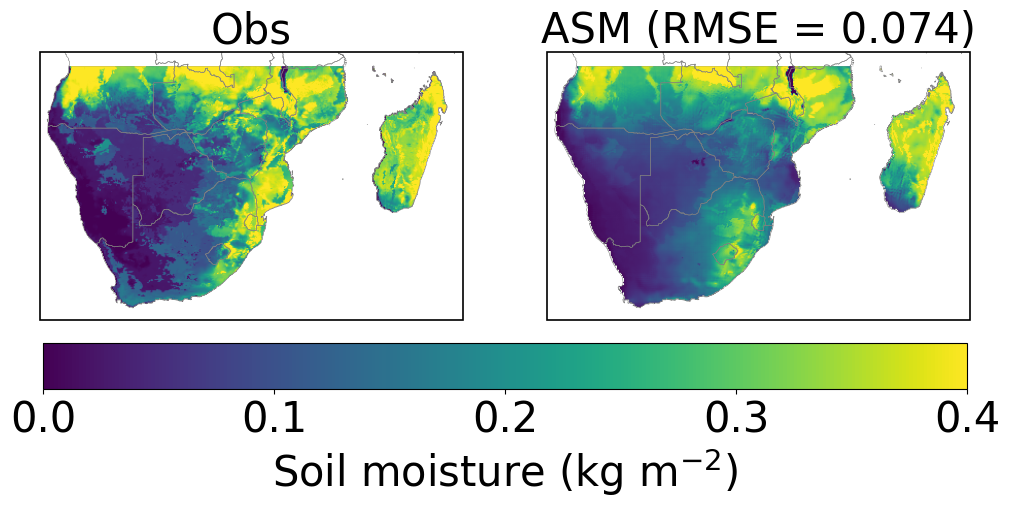

In [4]:
world = gpd.read_file('../../Data/country/世界国家.shp')

if lat64[0] > lat64[-1]:
    era5_masked = era5_masked[::-1, :]
    preds_masked = preds_masked[::-1, :]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

im0 = axes[0].imshow(
    era5_masked,
    origin='lower',
    extent=[lon64.min(), lon64.max(), lat64.min(), lat64.max()],
    vmin=0,
    vmax=0.4
)
axes[0].set_xlim(11, 52)
axes[0].set_ylim(-36, -10)
world.plot(ax=axes[0], facecolor='none', edgecolor='gray', linewidth=0.4)
axes[0].set_title('Obs', fontsize=30)

im1 = axes[1].imshow(
    preds_masked,
    origin='lower',
    extent=[lon64.min(), lon64.max(), lat64.min(), lat64.max()],
    vmin=0,
    vmax=0.4
)
axes[1].set_xlim(11, 52)
axes[1].set_ylim(-36, -10)
world.plot(ax=axes[1], facecolor='none', edgecolor='gray', linewidth=0.4)
axes[1].set_title(f'ASM (RMSE = {rmse:.3f})', fontsize=30)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

cbar = fig.colorbar(
    im0, 
    ax=axes,
    orientation='horizontal',
    fraction=0.10,    
    pad=0.05           
)
cbar.ax.tick_params(labelsize=30)
cbar.set_label('Soil moisture (kg m$^{-2}$)', fontsize=30)

plt.savefig('spatial_SAF.png', dpi = 300, bbox_inches='tight')
plt.show()